# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix,roc_curve, auc,f1_score
from sklearn.calibration import CalibratedClassifierCV
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

import re
from bs4 import BeautifulSoup
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('./Dataset/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1


#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:34<00:00, 2357.19it/s]


In [23]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.
def concatenateSummaryWithText(str1, str2):
    return str1 + ' ' + str2

preprocessed_summary = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    #sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())
    
preprocessed_reviews = list(map(concatenateSummaryWithText, preprocessed_reviews, preprocessed_summary))
final['CleanedText'] = preprocessed_reviews
final['CleanedText'] = final['CleanedText'].astype('str')

100%|██████████| 364171/364171 [00:08<00:00, 44607.29it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
# #BoW
# count_vect = CountVectorizer() #in scikit-learn
# count_vect.fit(preprocessed_reviews)
# print("some feature names ", count_vect.get_feature_names()[:10])
# print('='*50)

# final_counts = count_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_counts))
# print("the shape of out text BOW vectorizer ",final_counts.get_shape())
# print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [26]:
# #bi-gram, tri-gram and n-gram

# #removing stop words like "not" should be avoided before building n-grams
# # count_vect = CountVectorizer(ngram_range=(1,2))
# # please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# # you can choose these numebrs min_df=10, max_features=5000, of your choice
# count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
# final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_bigram_counts))
# print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [27]:
# tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
# tf_idf_vect.fit(preprocessed_reviews)
# print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
# print('='*50)

# final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_tf_idf))
# print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [28]:
# # Train your own Word2Vec model using your own text corpus
# i=0
# list_of_sentance=[]
# for sentance in preprocessed_reviews:
#     list_of_sentance.append(sentance.split())

In [29]:
# # Using Google News Word2Vectors

# # in this project we are using a pretrained model by google
# # its 3.3G file, once you load this into your memory 
# # it occupies ~9Gb, so please do this step only if you have >12G of ram
# # we will provide a pickle file wich contains a dict , 
# # and it contains all our courpus words as keys and  model[word] as values
# # To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# # from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# # it's 1.9GB in size.


# # http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# # you can comment this whole cell
# # or change these varible according to your need

# is_your_ram_gt_16g=False
# want_to_use_google_w2v = False
# want_to_train_w2v = True

# if want_to_train_w2v:
#     # min_count = 5 considers only words that occured atleast 5 times
#     w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
#     print(w2v_model.wv.most_similar('great'))
#     print('='*50)
#     print(w2v_model.wv.most_similar('worst'))
    
# elif want_to_use_google_w2v and is_your_ram_gt_16g:
#     if os.path.isfile('GoogleNews-vectors-negative300.bin'):
#         w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#         print(w2v_model.wv.most_similar('great'))
#         print(w2v_model.wv.most_similar('worst'))
#     else:
#         print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [30]:
# w2v_words = list(w2v_model.wv.vocab)
# print("number of words that occured minimum 5 times ",len(w2v_words))
# print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# # average Word2Vec
# # compute average word2vec for each review.
# sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# for sent in tqdm(list_of_sentance): # for each review/sentence
#     sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
#     cnt_words =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words:
#             vec = w2v_model.wv[word]
#             sent_vec += vec
#             cnt_words += 1
#     if cnt_words != 0:
#         sent_vec /= cnt_words
#     sent_vectors.append(sent_vec)
# print(len(sent_vectors))
# print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# model = TfidfVectorizer()
# tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# # TF-IDF weighted Word2Vec
# tfidf_feat = model.get_feature_names() # tfidf words/col-names
# # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

# tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
# row=0;
# for sent in tqdm(list_of_sentance): # for each review/sentence 
#     sent_vec = np.zeros(50) # as word vectors are of zero length
#     weight_sum =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words and word in tfidf_feat:
#             vec = w2v_model.wv[word]
# #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
#             # to reduce the computation we are 
#             # dictionary[word] = idf value of word in whole courpus
#             # sent.count(word) = tf valeus of word in this review
#             tf_idf = dictionary[word]*(sent.count(word)/len(sent))
#             sent_vec += (vec * tf_idf)
#             weight_sum += tf_idf
#     if weight_sum != 0:
#         sent_vec /= weight_sum
#     tfidf_sent_vectors.append(sent_vec)
#     row += 1

# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

In [34]:
global result_report
result_report = pd.DataFrame(columns=['VECTORIZER', 'MODEL', 'DATASET-SIZE', 'HYPERPARAMETER', 'PENALTY', 'F1_SCORE', 'AUC'])

In [35]:
#Sorting according to the time for time-based splitting
final['Time'] = pd.to_datetime(final['Time'], unit='s')
final = final.sort_values(by='Time', ascending=True)

In [36]:
#Using only 100k points for LINEAR-SVM
min_final = final.sample(n=100000)
x_train, x_test, y_train, y_test = train_test_split(min_final['CleanedText'], min_final['Score'], test_size=0.30)

alpha_range = list([10 ** i for i in range(-4, 4, 1)])
penalty_range = list(['l1', 'l2'])

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [37]:
# Applying BOW Vectorizer
bow_model = CountVectorizer()
bow_model.fit(x_train)

x_train_bow = bow_model.transform(x_train)
x_test_bow = bow_model.transform(x_test)

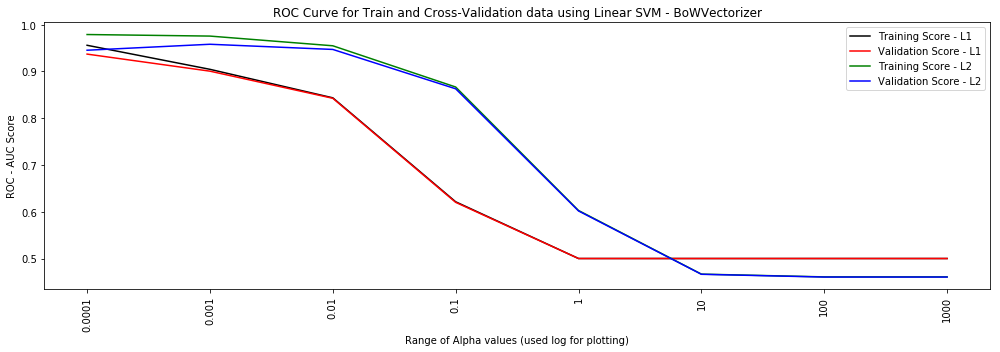

In [38]:
# Applying SGDClassifier to Alpha_ranges using GridSearch CV=10
sgd = SGDClassifier()
parameters = {'alpha': alpha_range, 'penalty': penalty_range}
clf = GridSearchCV(sgd, parameters, cv=10, scoring = 'roc_auc', return_train_score=True)
clf.fit(x_train_bow, y_train)

def returnScoresForHyperparameters(scores, params):
    i = 0
    score_l1 = []
    score_l2 = []
    train_scores = scores
    for paramsObj in params:
        value = train_scores[i]
        if paramsObj['penalty'] == 'l1':
            score_l1.append(value)
        elif paramsObj['penalty'] == 'l2':
            score_l2.append(value)
        i+=1
    return score_l1, score_l2

mean_train_score_l1, mean_train_score_l2 = returnScoresForHyperparameters(clf.cv_results_['mean_train_score'], 
                                                                          clf.cv_results_['params'])
mean_test_score_l1, mean_test_score_l2 = returnScoresForHyperparameters(clf.cv_results_['mean_test_score'], 
                                                                          clf.cv_results_['params'])

plt.figure(figsize=(14, 5))
#Plot mean accuracy for train and cv set scores
plt.plot(np.log(alpha_range), mean_train_score_l1, label='Training Score - L1', color='black')
plt.plot(np.log(alpha_range), mean_test_score_l1, label='Validation Score - L1', color='red')
plt.plot(np.log(alpha_range), mean_train_score_l2, label='Training Score - L2', color='green')
plt.plot(np.log(alpha_range), mean_test_score_l2, label='Validation Score - L2', color='blue')
plt.xticks(np.log(alpha_range), alpha_range, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Linear SVM - BoWVectorizer")
plt.xlabel("Range of Alpha values (used log for plotting)")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

Optimal Alpha: 0.001 with Penalty: l2 with AUC: 96.34%


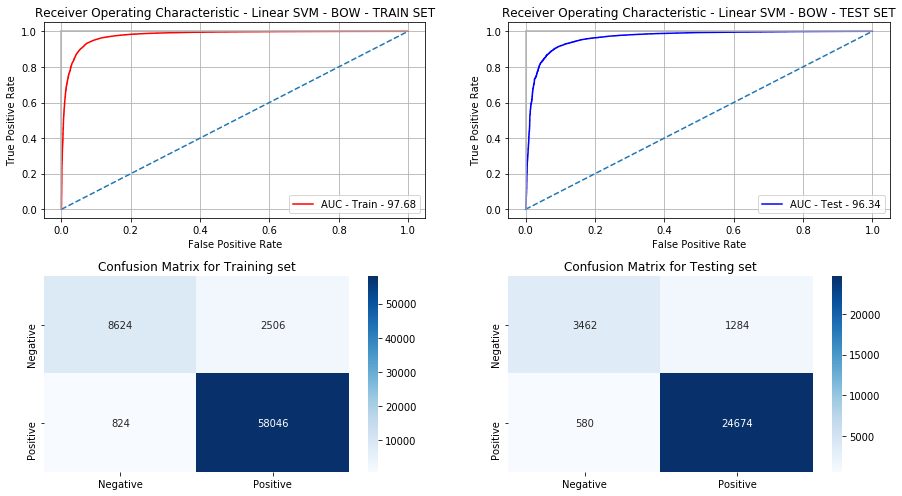

In [39]:
optimal_alpha = clf.best_params_['alpha']
optimal_penalty = clf.best_params_['penalty']

sgd = SGDClassifier(loss = 'hinge', alpha = optimal_alpha, penalty=optimal_penalty)
ccv_clf = CalibratedClassifierCV(sgd, cv=10)
ccv_clf.fit(x_train_bow, y_train)

# Get predicted values for test data
pred_train = ccv_clf.predict(x_train_bow)
pred_test = ccv_clf.predict(x_test_bow)
pred_proba_train = ccv_clf.predict_proba(x_train_bow)[:,1]
pred_proba_test = ccv_clf.predict_proba(x_test_bow)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal Alpha: {} with Penalty: {} with AUC: {:.2f}%".format(optimal_alpha, optimal_penalty, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER': 'Bag of Words(BoW)',
                                      'MODEL': 'LINEAR-SVM',
                                      'DATASET-SIZE': '{0:,.0f}'.format(int(min_final.shape[0])),
                                      'PENALTY': optimal_penalty,
                                      'HYPERPARAMETER': optimal_alpha,
                                      'F1_SCORE': f1_sc, 'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Linear SVM - BOW - TRAIN SET')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for test set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Linear SVM - BOW - TEST SET')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for train
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for test
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

### [5.1.1.1] Feature Importance (Linear SVM on BoW)

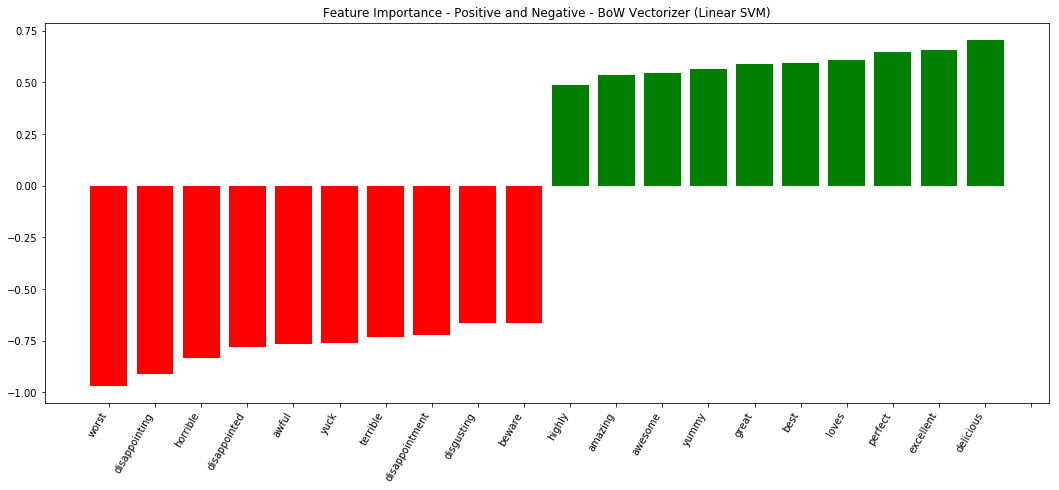

In [40]:
sgd_clf = SGDClassifier(loss = 'hinge', alpha = optimal_alpha, penalty=optimal_penalty)
sgd_clf.fit(x_train_bow, y_train)
coef = sgd_clf.coef_.ravel()
feature_names = bow_model.get_feature_names()
top_positive_coef = np.argsort(coef)[-10:]
top_negative_coef = np.argsort(coef)[:10]
top_coefficients = np.hstack([top_negative_coef, top_positive_coef])

plt.figure(figsize=(18, 7))
plt.title("Feature Importance - Positive and Negative - BoW Vectorizer (Linear SVM)")
colors = ['red' if c < 0 else 'green' for c in coef[top_coefficients]]
plt.bar(np.arange(2 * 10), coef[top_coefficients], color=colors)
feature_names = np.array(feature_names)
plt.xticks(np.arange(0, 1 + 2 * 10), feature_names[top_coefficients], rotation=60, ha='right')
plt.show()

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [41]:
# Applying TFIDF Vectorizer
tfidf_model = TfidfVectorizer()
tfidf_model.fit(x_train)

x_train_tfidf = tfidf_model.transform(x_train)
x_test_tfidf = tfidf_model.transform(x_test)

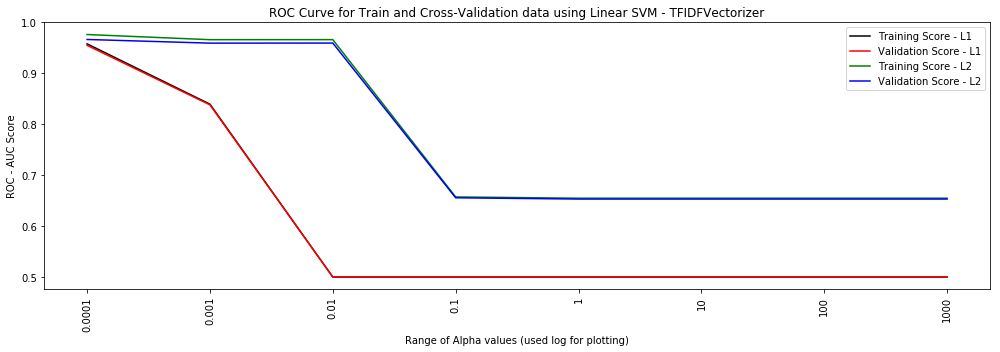

In [42]:
# Applying SGDClassifier to Alpha_ranges using GridSearch CV=10
sgd = SGDClassifier()
parameters = {'alpha': alpha_range, 'penalty': penalty_range}
clf = GridSearchCV(sgd, parameters, cv=10, scoring = 'roc_auc', return_train_score=True)
clf.fit(x_train_tfidf, y_train)

def returnScoresForHyperparameters(scores, params):
    i = 0
    score_l1 = []
    score_l2 = []
    train_scores = scores
    for paramsObj in params:
        value = train_scores[i]
        if paramsObj['penalty'] == 'l1':
            score_l1.append(value)
        elif paramsObj['penalty'] == 'l2':
            score_l2.append(value)
        i+=1
    return score_l1, score_l2

mean_train_score_l1, mean_train_score_l2 = returnScoresForHyperparameters(clf.cv_results_['mean_train_score'], 
                                                                          clf.cv_results_['params'])
mean_test_score_l1, mean_test_score_l2 = returnScoresForHyperparameters(clf.cv_results_['mean_test_score'], 
                                                                          clf.cv_results_['params'])

plt.figure(figsize=(14, 5))
#Plot mean accuracy for train and cv set scores
plt.plot(np.log(alpha_range), mean_train_score_l1, label='Training Score - L1', color='black')
plt.plot(np.log(alpha_range), mean_test_score_l1, label='Validation Score - L1', color='red')
plt.plot(np.log(alpha_range), mean_train_score_l2, label='Training Score - L2', color='green')
plt.plot(np.log(alpha_range), mean_test_score_l2, label='Validation Score - L2', color='blue')
plt.xticks(np.log(alpha_range), alpha_range, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Linear SVM - TFIDFVectorizer")
plt.xlabel("Range of Alpha values (used log for plotting)")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

Optimal Alpha: 0.0001 with Penalty: l2 with AUC: 96.82%


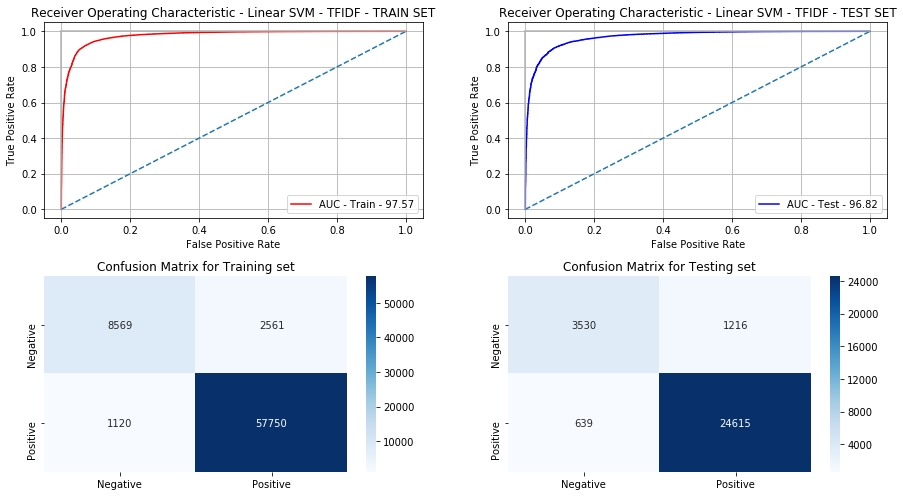

In [43]:
optimal_alpha = clf.best_params_['alpha']
optimal_penalty = clf.best_params_['penalty']

sgd = SGDClassifier(loss = 'hinge', alpha = optimal_alpha, penalty=optimal_penalty)
ccv_clf = CalibratedClassifierCV(sgd, cv=10)
ccv_clf.fit(x_train_tfidf, y_train)

# Get predicted values for test data
pred_train = ccv_clf.predict(x_train_tfidf)
pred_test = ccv_clf.predict(x_test_tfidf)
pred_proba_train = ccv_clf.predict_proba(x_train_tfidf)[:,1]
pred_proba_test = ccv_clf.predict_proba(x_test_tfidf)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal Alpha: {} with Penalty: {} with AUC: {:.2f}%".format(optimal_alpha, optimal_penalty, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER': 'TF-IDF',
                                      'MODEL': 'LINEAR-SVM',
                                      'DATASET-SIZE': '{0:,.0f}'.format(int(min_final.shape[0])),
                                      'PENALTY': optimal_penalty,
                                      'HYPERPARAMETER': optimal_alpha,
                                      'F1_SCORE': f1_sc, 'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Linear SVM - TFIDF - TRAIN SET')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for test set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Linear SVM - TFIDF - TEST SET')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for train
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for test
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

### [5.1.2.1] Feature Importance (Linear SVM on TF-IDF)

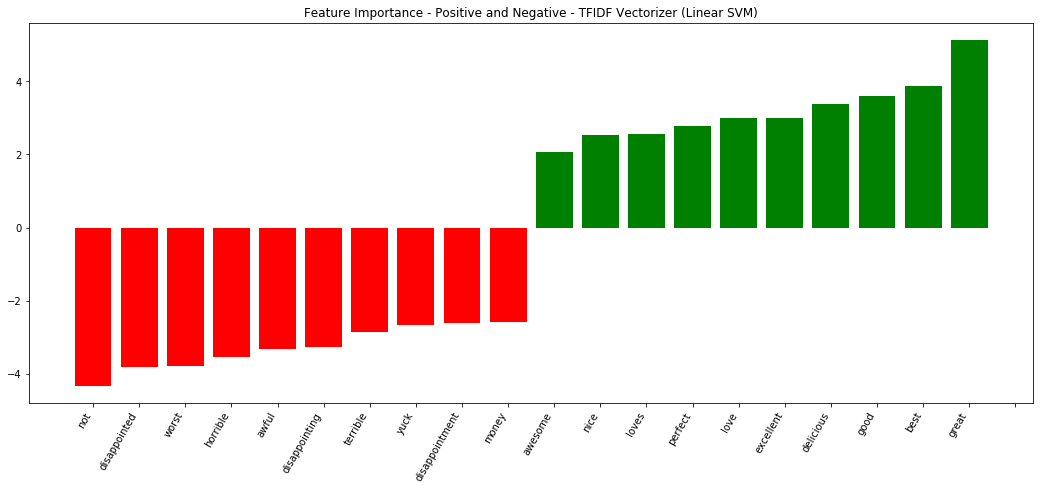

In [44]:
sgd_clf = SGDClassifier(loss = 'hinge', alpha = optimal_alpha, penalty=optimal_penalty)
sgd_clf.fit(x_train_tfidf, y_train)
coef = sgd_clf.coef_.ravel()
feature_names = tfidf_model.get_feature_names()
top_positive_coef = np.argsort(coef)[-10:]
top_negative_coef = np.argsort(coef)[:10]
top_coefficients = np.hstack([top_negative_coef, top_positive_coef])

plt.figure(figsize=(18, 7))
plt.title("Feature Importance - Positive and Negative - TFIDF Vectorizer (Linear SVM)")
colors = ['red' if c < 0 else 'green' for c in coef[top_coefficients]]
plt.bar(np.arange(2 * 10), coef[top_coefficients], color=colors)
feature_names = np.array(feature_names)
plt.xticks(np.arange(0, 1 + 2 * 10), feature_names[top_coefficients], rotation=60, ha='right')
plt.show()

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [45]:
list_of_sent_train = []
list_of_sent_test = []

for sent in x_train:
    list_of_sent_train.append(sent.split())
for sent in x_test:
    list_of_sent_test.append(sent.split())
    
w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=8)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  16643
sample words  ['cramp', 'handling', 'branch', 'debated', 'slather', 'expedient', 'si', 'pillows', 'shouldnt', 'citizen', 'xylichew', 'chewer', 'aftertastes', 'frost', 'stir', 'worth', 'nicknamed', 'mugs', 'fudgy', 'vera', 'discerning', 'limit', 'paraphrase', 'fries', 'stephen', 'burlap', 'lickin', 'someones', 'gr', 'steaks', 'addiction', 'gooood', 'alcohol', 'exception', 'travel', 'waggin', 'listings', 'teas', 'spinach', 'static', 'wore', 'mylar', 'cautionary', 'petfooddirect', 'greenhouse', 'dukan', 'bonito', 'lure', 'bloody', 'paddle']


In [46]:
# compute average word2vec for each review for train data 
avgw2v_train = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_train): # for each review/sentence
    sent_vec = np.zeros(50)
    cnt_words = 0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgw2v_train.append(sent_vec)
print(len(avgw2v_train))
print(len(avgw2v_train[0]))

100%|██████████| 70000/70000 [16:55<00:00, 68.94it/s] 

70000
50


In [47]:
# compute average word2vec for each review for test data 
avgw2v_test = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec = np.zeros(50) 
    cnt_words = 0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgw2v_test.append(sent_vec)
print(len(avgw2v_test))
print(len(avgw2v_test[0]))

100%|██████████| 30000/30000 [07:05<00:00, 70.55it/s]

30000
50


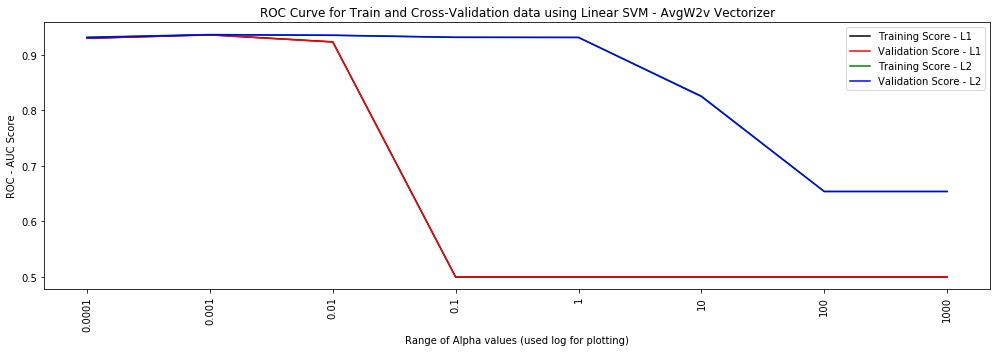

In [48]:
# Applying SGDClassifier to Alpha_ranges using GridSearch CV=10
sgd = SGDClassifier()
parameters = {'alpha': alpha_range, 'penalty': penalty_range}
clf = GridSearchCV(sgd, parameters, cv=10, scoring = 'roc_auc', return_train_score=True)
clf.fit(avgw2v_train, y_train)

def returnScoresForHyperparameters(scores, params):
    i = 0
    score_l1 = []
    score_l2 = []
    train_scores = scores
    for paramsObj in params:
        value = train_scores[i]
        if paramsObj['penalty'] == 'l1':
            score_l1.append(value)
        elif paramsObj['penalty'] == 'l2':
            score_l2.append(value)
        i+=1
    return score_l1, score_l2

mean_train_score_l1, mean_train_score_l2 = returnScoresForHyperparameters(clf.cv_results_['mean_train_score'], 
                                                                          clf.cv_results_['params'])
mean_test_score_l1, mean_test_score_l2 = returnScoresForHyperparameters(clf.cv_results_['mean_test_score'], 
                                                                          clf.cv_results_['params'])

plt.figure(figsize=(14, 5))
#Plot mean accuracy for train and cv set scores
plt.plot(np.log(alpha_range), mean_train_score_l1, label='Training Score - L1', color='black')
plt.plot(np.log(alpha_range), mean_test_score_l1, label='Validation Score - L1', color='red')
plt.plot(np.log(alpha_range), mean_train_score_l2, label='Training Score - L2', color='green')
plt.plot(np.log(alpha_range), mean_test_score_l2, label='Validation Score - L2', color='blue')
plt.xticks(np.log(alpha_range), alpha_range, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Linear SVM - AvgW2v Vectorizer")
plt.xlabel("Range of Alpha values (used log for plotting)")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

Optimal Alpha: 0.001 with Penalty: l2 with AUC: 93.82%


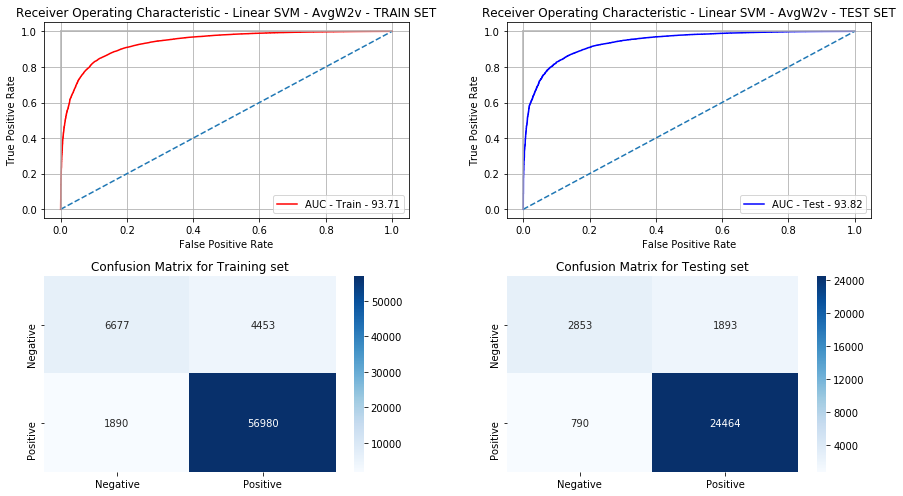

In [49]:
optimal_alpha = clf.best_params_['alpha']
optimal_penalty = clf.best_params_['penalty']

sgd = SGDClassifier(loss = 'hinge', alpha = optimal_alpha, penalty=optimal_penalty)
ccv_clf = CalibratedClassifierCV(sgd, cv=10)
ccv_clf.fit(avgw2v_train, y_train)

# Get predicted values for test data
pred_train = ccv_clf.predict(avgw2v_train)
pred_test = ccv_clf.predict(avgw2v_test)
pred_proba_train = ccv_clf.predict_proba(avgw2v_train)[:,1]
pred_proba_test = ccv_clf.predict_proba(avgw2v_test)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal Alpha: {} with Penalty: {} with AUC: {:.2f}%".format(optimal_alpha, optimal_penalty, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER': 'Avg-W2V',
                                      'MODEL': 'LINEAR-SVM',
                                      'DATASET-SIZE': '{0:,.0f}'.format(int(min_final.shape[0])),
                                      'PENALTY': optimal_penalty,
                                      'HYPERPARAMETER': optimal_alpha,
                                      'F1_SCORE': f1_sc, 'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Linear SVM - AvgW2v - TRAIN SET')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for test set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Linear SVM - AvgW2v - TEST SET')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for train
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for test
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [50]:
model = TfidfVectorizer()
model.fit(x_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [51]:
#Creating the TFIDF W2V Training Set
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidfw2v_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2v_train.append(sent_vec)
    row += 1

100%|██████████| 70000/70000 [1:24:51<00:00, 13.75it/s]  


In [52]:
#Creating the TFIDF W2V Testing Set

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidfw2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2v_test.append(sent_vec)
    row += 1

100%|██████████| 30000/30000 [30:38<00:00, 26.48it/s] 


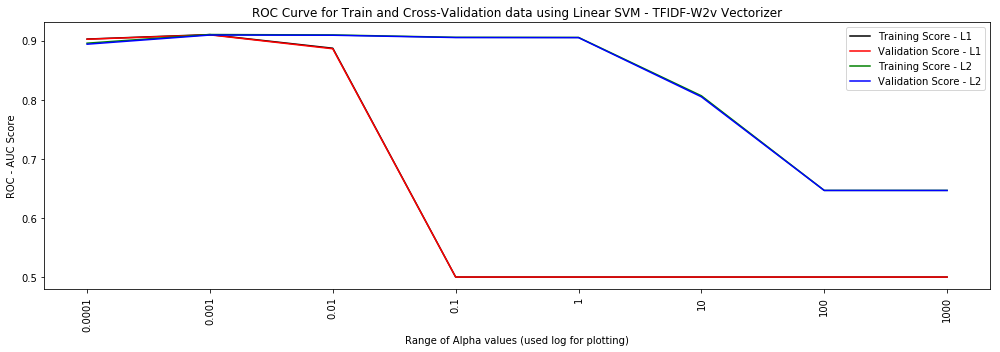

In [53]:
# Applying SGDClassifier to Alpha_ranges using GridSearch CV=10
sgd = SGDClassifier()
parameters = {'alpha': alpha_range, 'penalty': penalty_range}
clf = GridSearchCV(sgd, parameters, cv=10, scoring = 'roc_auc', return_train_score=True, n_jobs=-1)
clf.fit(tfidfw2v_train, y_train)

def returnScoresForHyperparameters(scores, params):
    i = 0
    score_l1 = []
    score_l2 = []
    train_scores = scores
    for paramsObj in params:
        value = train_scores[i]
        if paramsObj['penalty'] == 'l1':
            score_l1.append(value)
        elif paramsObj['penalty'] == 'l2':
            score_l2.append(value)
        i+=1
    return score_l1, score_l2

mean_train_score_l1, mean_train_score_l2 = returnScoresForHyperparameters(clf.cv_results_['mean_train_score'], 
                                                                          clf.cv_results_['params'])
mean_test_score_l1, mean_test_score_l2 = returnScoresForHyperparameters(clf.cv_results_['mean_test_score'], 
                                                                          clf.cv_results_['params'])

plt.figure(figsize=(14, 5))
#Plot mean accuracy for train and cv set scores
plt.plot(np.log(alpha_range), mean_train_score_l1, label='Training Score - L1', color='black')
plt.plot(np.log(alpha_range), mean_test_score_l1, label='Validation Score - L1', color='red')
plt.plot(np.log(alpha_range), mean_train_score_l2, label='Training Score - L2', color='green')
plt.plot(np.log(alpha_range), mean_test_score_l2, label='Validation Score - L2', color='blue')
plt.xticks(np.log(alpha_range), alpha_range, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Linear SVM - TFIDF-W2v Vectorizer")
plt.xlabel("Range of Alpha values (used log for plotting)")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

Optimal Alpha: 0.001 with Penalty: l1 with AUC: 91.02%


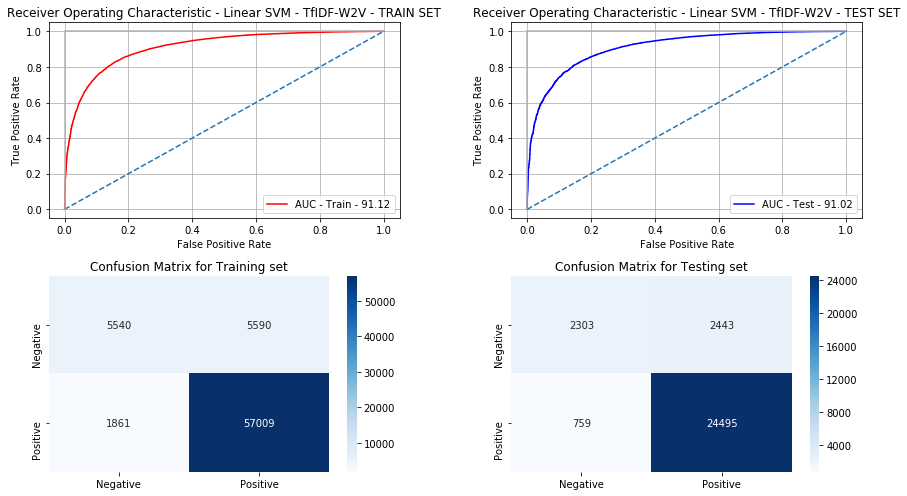

In [54]:
optimal_alpha = clf.best_params_['alpha']
optimal_penalty = clf.best_params_['penalty']

sgd = SGDClassifier(loss = 'hinge', alpha = optimal_alpha, penalty=optimal_penalty)
ccv_clf = CalibratedClassifierCV(sgd, cv=10)
ccv_clf.fit(tfidfw2v_train, y_train)

# Get predicted values for test data
pred_train = ccv_clf.predict(tfidfw2v_train)
pred_test = ccv_clf.predict(tfidfw2v_test)
pred_proba_train = ccv_clf.predict_proba(tfidfw2v_train)[:,1]
pred_proba_test = ccv_clf.predict_proba(tfidfw2v_test)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal Alpha: {} with Penalty: {} with AUC: {:.2f}%".format(optimal_alpha, optimal_penalty, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER': 'TFIDF-W2V',
                                      'MODEL': 'LINEAR-SVM',
                                      'DATASET-SIZE': '{0:,.0f}'.format(int(min_final.shape[0])),
                                      'PENALTY': optimal_penalty,
                                      'HYPERPARAMETER': optimal_alpha,
                                      'F1_SCORE': f1_sc, 'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Linear SVM - TfIDF-W2V - TRAIN SET')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for test set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Linear SVM - TfIDF-W2V - TEST SET')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for train
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for test
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

## [5.2] RBF SVM

In [55]:
#Using only 30k points for Kernel SVM (RBF Kernel)
min_final = final.sample(n=30000)
x_train, x_test, y_train, y_test = train_test_split(min_final['CleanedText'], min_final['Score'], test_size=0.30)

c_range = list([10 ** i for i in range(-4, 4, 1)])

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [56]:
# Applying BOW Vectorizer
bow_model = CountVectorizer(min_df = 5, max_features=500)
bow_model.fit(x_train)

x_train_bow = bow_model.transform(x_train)
x_test_bow = bow_model.transform(x_test)

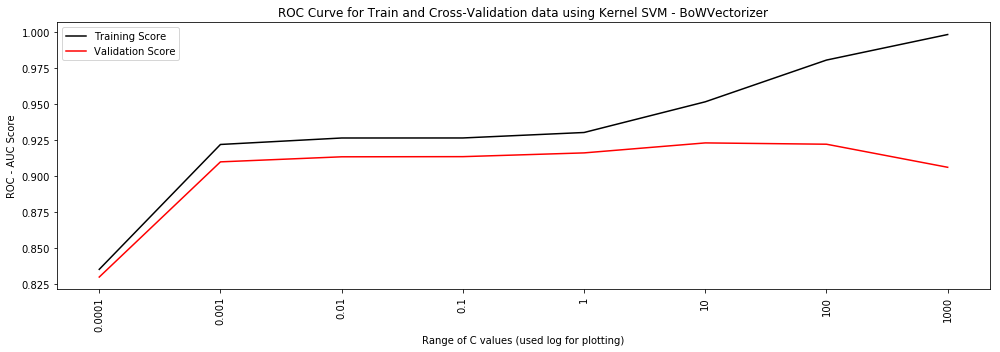

In [57]:
# Applying SGDClassifier to Alpha_ranges using GridSearch CV=10
svc = SVC(kernel='rbf')

parameters = {'C': c_range}
clf = GridSearchCV(svc, parameters, cv=10, scoring = 'roc_auc', return_train_score=True)
clf.fit(x_train_bow, y_train)

mean_train_score = clf.cv_results_['mean_train_score']
mean_test_score = clf.cv_results_['mean_test_score']

plt.figure(figsize=(14, 5))
#Plot mean accuracy for train and cv set scores
plt.plot(np.log(c_range), mean_train_score, label='Training Score', color='black')
plt.plot(np.log(c_range), mean_test_score, label='Validation Score', color='red')

plt.xticks(np.log(c_range), c_range, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Kernel SVM - BoWVectorizer")
plt.xlabel("Range of C values (used log for plotting)")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

Optimal C: 10  with AUC: 92.27%


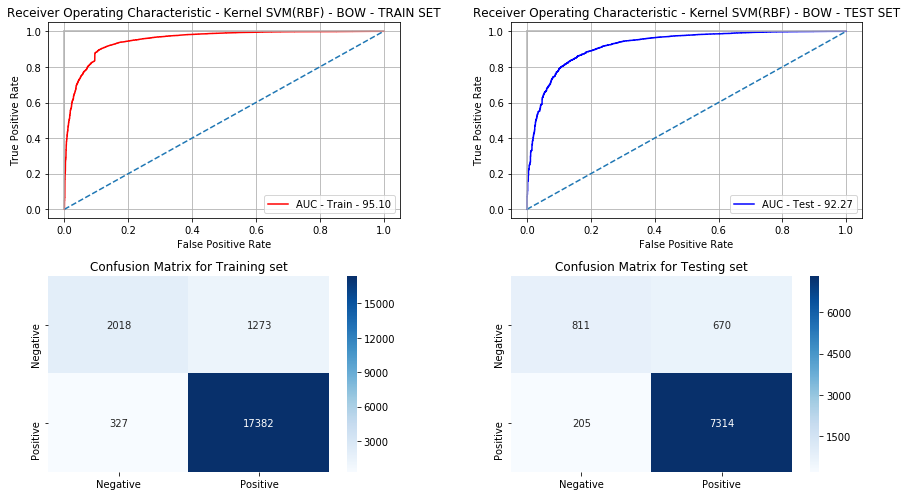

In [58]:
optimal_c = clf.best_params_['C']

clf = SVC(kernel='rbf',C=optimal_c, probability=True)
clf.fit(x_train_bow, y_train)

# Get predicted values for test data
pred_train = clf.predict(x_train_bow)
pred_test = clf.predict(x_test_bow)
pred_proba_train = clf.predict_proba(x_train_bow)[:,1]
pred_proba_test = clf.predict_proba(x_test_bow)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal C: {}  with AUC: {:.2f}%".format(optimal_c, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER': 'Bag of Words(BoW)',
                                      'MODEL': 'KERNEL-SVM(RBF)',
                                      'DATASET-SIZE': '{0:,.0f}'.format(int(min_final.shape[0])),
                                      'PENALTY': '-',
                                      'HYPERPARAMETER': optimal_c,
                                      'F1_SCORE': f1_sc, 'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Kernel SVM(RBF) - BOW - TRAIN SET')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for test set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Kernel SVM(RBF) - BOW - TEST SET')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for train
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for test
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [59]:
# Applying TFIDF Vectorizer
tfidf_model = TfidfVectorizer(min_df = 5, max_features=500)
tfidf_model.fit(x_train)

x_train_tfidf = tfidf_model.transform(x_train)
x_test_tfidf = tfidf_model.transform(x_test)

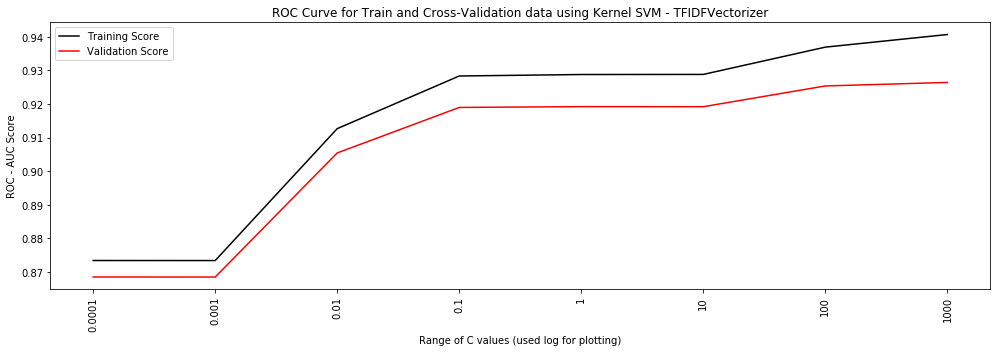

In [60]:
# Applying SGDClassifier to Alpha_ranges using GridSearch CV=10
svc = SVC(kernel='rbf')

parameters = {'C': c_range}
clf = GridSearchCV(svc, parameters, cv=10, scoring = 'roc_auc', return_train_score=True)
clf.fit(x_train_tfidf, y_train)

mean_train_score = clf.cv_results_['mean_train_score']
mean_test_score = clf.cv_results_['mean_test_score']

plt.figure(figsize=(14, 5))
#Plot mean accuracy for train and cv set scores
plt.plot(np.log(c_range), mean_train_score, label='Training Score', color='black')
plt.plot(np.log(c_range), mean_test_score, label='Validation Score', color='red')

plt.xticks(np.log(c_range), c_range, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Kernel SVM - TFIDFVectorizer")
plt.xlabel("Range of C values (used log for plotting)")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

Optimal C: 1000  with AUC: 92.78%


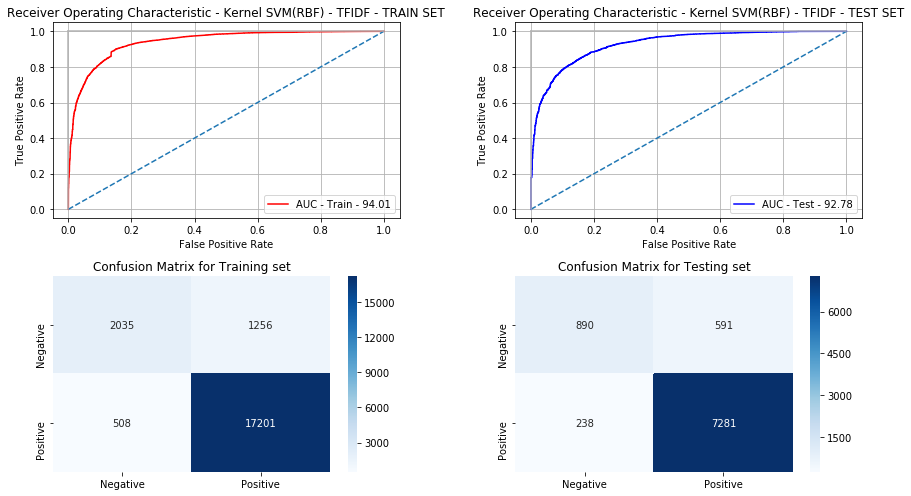

In [61]:
optimal_c = clf.best_params_['C']

clf = SVC(kernel='rbf',C=optimal_c, probability=True)
clf.fit(x_train_tfidf, y_train)

# Get predicted values for test data
pred_train = clf.predict(x_train_tfidf)
pred_test = clf.predict(x_test_tfidf)
pred_proba_train = clf.predict_proba(x_train_tfidf)[:,1]
pred_proba_test = clf.predict_proba(x_test_tfidf)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal C: {}  with AUC: {:.2f}%".format(optimal_c, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER': 'TF-IDF',
                                      'MODEL': 'KERNEL-SVM(RBF)',
                                      'DATASET-SIZE': '{0:,.0f}'.format(int(min_final.shape[0])),
                                      'PENALTY': '-',
                                      'HYPERPARAMETER': optimal_c,
                                      'F1_SCORE': f1_sc, 'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Kernel SVM(RBF) - TFIDF - TRAIN SET')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for test set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Kernel SVM(RBF) - TFIDF - TEST SET')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for train
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for test
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [62]:
list_of_sent_train = []
list_of_sent_test = []

for sent in x_train:
    list_of_sent_train.append(sent.split())
for sent in x_test:
    list_of_sent_test.append(sent.split())
    
w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=8)
w2v_words = list(w2v_model.wv.vocab)


# compute average word2vec for each review for train data 
avgw2v_train = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_train): # for each review/sentence
    sent_vec = np.zeros(50)
    cnt_words = 0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgw2v_train.append(sent_vec)
    
    
# compute average word2vec for each review for test data 
avgw2v_test = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec = np.zeros(50) 
    cnt_words = 0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    avgw2v_test.append(sent_vec)

100%|██████████| 9000/9000 [01:03<00:00, 130.88it/s]


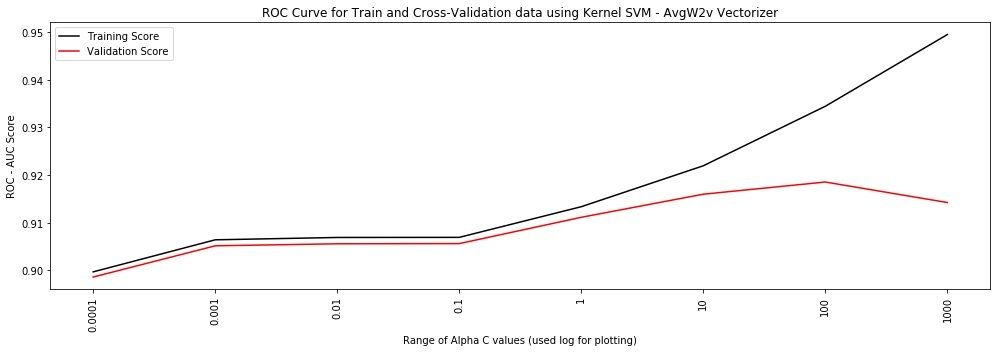

In [63]:
# Applying SGDClassifier to Alpha_ranges using GridSearch CV=10
svc = SVC(kernel='rbf')

parameters = {'C': c_range}
clf = GridSearchCV(svc, parameters, cv=10, scoring = 'roc_auc', return_train_score=True)
clf.fit(avgw2v_train, y_train)

mean_train_score = clf.cv_results_['mean_train_score']
mean_test_score = clf.cv_results_['mean_test_score']

plt.figure(figsize=(14, 5))
#Plot mean accuracy for train and cv set scores
plt.plot(np.log(c_range), mean_train_score, label='Training Score', color='black')
plt.plot(np.log(c_range), mean_test_score, label='Validation Score', color='red')

plt.xticks(np.log(c_range), c_range, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Kernel SVM - AvgW2v Vectorizer")
plt.xlabel("Range of Alpha C values (used log for plotting)")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

Optimal C: 100  with AUC: 92.23%


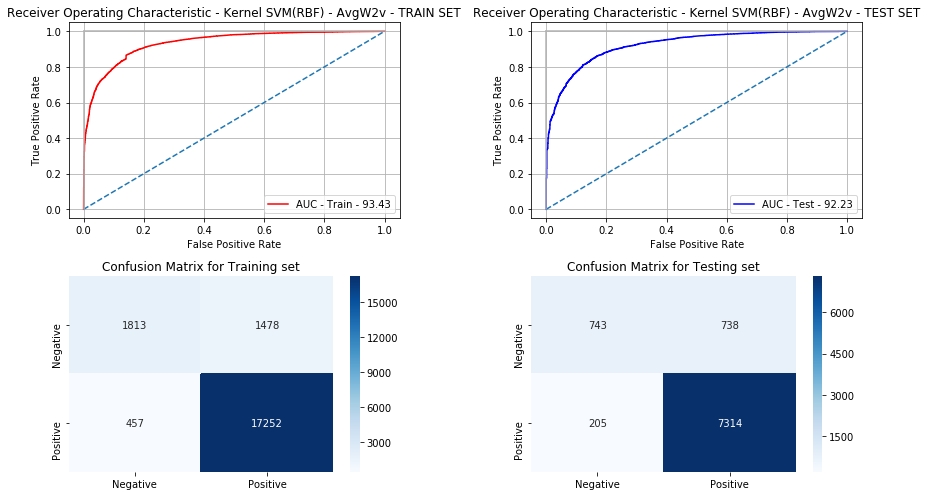

In [64]:
optimal_c = clf.best_params_['C']

clf = SVC(kernel='rbf',C=optimal_c, probability=True)
clf.fit(avgw2v_train, y_train)

# Get predicted values for test data
pred_train = clf.predict(avgw2v_train)
pred_test = clf.predict(avgw2v_test)
pred_proba_train = clf.predict_proba(avgw2v_train)[:,1]
pred_proba_test = clf.predict_proba(avgw2v_test)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal C: {}  with AUC: {:.2f}%".format(optimal_c, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER': 'Avg-W2V',
                                      'MODEL': 'KERNEL-SVM(RBF)',
                                      'DATASET-SIZE': '{0:,.0f}'.format(int(min_final.shape[0])),
                                      'PENALTY': '-',
                                      'HYPERPARAMETER': optimal_c,
                                      'F1_SCORE': f1_sc, 'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Kernel SVM(RBF) - AvgW2v - TRAIN SET')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for test set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Kernel SVM(RBF) - AvgW2v - TEST SET')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for train
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for test
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [65]:
model = TfidfVectorizer()
model.fit(x_train)


#Creating the TFIDF W2V Training Set
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidfw2v_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2v_train.append(sent_vec)
    row += 1
    
    
    
#Creating the TFIDF W2V Testing Set

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidfw2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidfw2v_test.append(sent_vec)
    row += 1

100%|██████████| 9000/9000 [04:47<00:00, 31.28it/s]


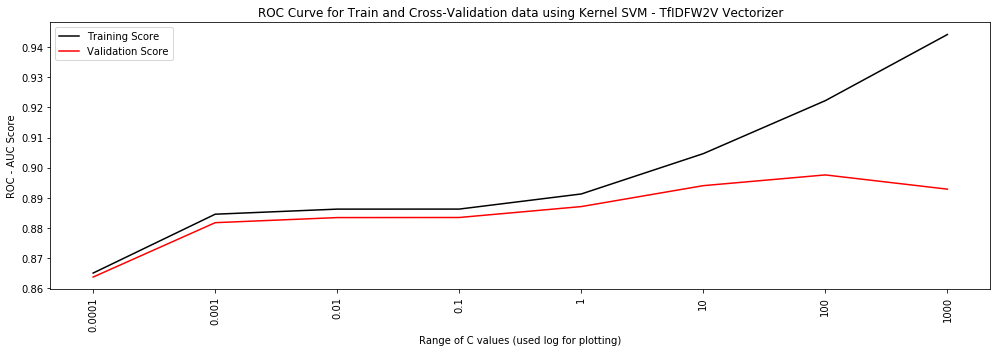

In [66]:
# Applying SGDClassifier to Alpha_ranges using GridSearch CV=10
svc = SVC(kernel='rbf')

parameters = {'C': c_range}
clf = GridSearchCV(svc, parameters, cv=10, scoring = 'roc_auc', return_train_score=True)
clf.fit(tfidfw2v_train, y_train)

mean_train_score = clf.cv_results_['mean_train_score']
mean_test_score = clf.cv_results_['mean_test_score']

plt.figure(figsize=(14, 5))
#Plot mean accuracy for train and cv set scores
plt.plot(np.log(c_range), mean_train_score, label='Training Score', color='black')
plt.plot(np.log(c_range), mean_test_score, label='Validation Score', color='red')

plt.xticks(np.log(c_range), c_range, rotation='vertical')

# Create plot
plt.title("ROC Curve for Train and Cross-Validation data using Kernel SVM - TfIDFW2V Vectorizer")
plt.xlabel("Range of C values (used log for plotting)")
plt.ylabel("ROC - AUC Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

Optimal C: 100  with AUC: 90.22%


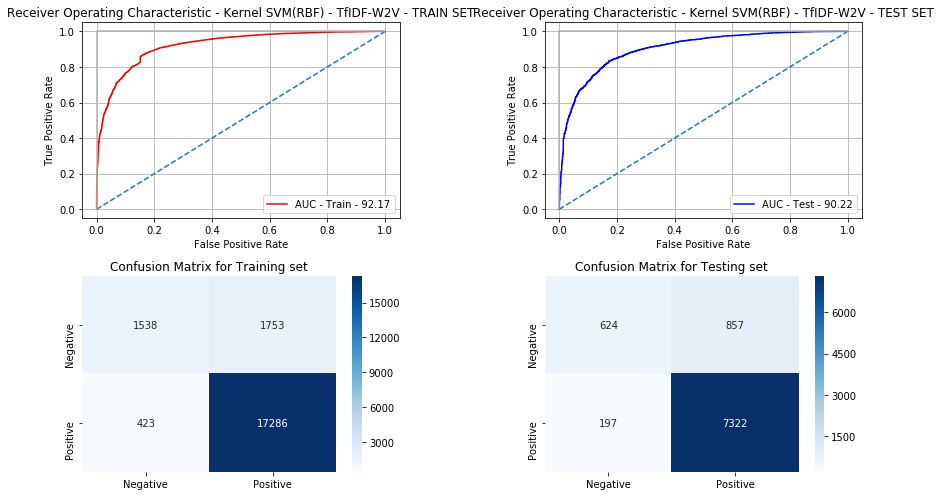

In [67]:
optimal_c = clf.best_params_['C']

clf = SVC(kernel='rbf',C=optimal_c, probability=True)
clf.fit(tfidfw2v_train, y_train)

# Get predicted values for test data
pred_train = clf.predict(tfidfw2v_train)
pred_test = clf.predict(tfidfw2v_test)
pred_proba_train = clf.predict_proba(tfidfw2v_train)[:,1]
pred_proba_test = clf.predict_proba(tfidfw2v_test)[:,1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_proba_train, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_proba_test, pos_label=1)
conf_mat_train = confusion_matrix(y_train, pred_train, labels=[0, 1])
conf_mat_test = confusion_matrix(y_test, pred_test, labels=[0, 1])
f1_sc = f1_score(y_test, pred_test, average='binary', pos_label=1)
auc_sc_train = auc(fpr_train, tpr_train)
auc_sc = auc(fpr_test, tpr_test)

print("Optimal C: {}  with AUC: {:.2f}%".format(optimal_c, float(auc_sc*100)))
#Saving the report in a global variable
result_report = result_report.append({'VECTORIZER': 'TFIDF-W2V',
                                      'MODEL': 'KERNEL-SVM(RBF)',
                                      'DATASET-SIZE': '{0:,.0f}'.format(int(min_final.shape[0])),
                                      'PENALTY': '-',
                                      'HYPERPARAMETER': optimal_c,
                                      'F1_SCORE': f1_sc, 'AUC': auc_sc
                                     }, ignore_index=True)


plt.figure(figsize=(13,7))
# Plot ROC curve for training set
plt.subplot(2, 2, 1)
plt.title('Receiver Operating Characteristic - Kernel SVM(RBF) - TfIDF-W2V - TRAIN SET')
plt.plot(fpr_train, tpr_train, color='red', label='AUC - Train - {:.2f}'.format(float(auc_sc_train * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

# Plot ROC curve for test set
plt.subplot(2, 2, 2)
plt.title('Receiver Operating Characteristic - Kernel SVM(RBF) - TfIDF-W2V - TEST SET')
plt.plot(fpr_test, tpr_test, color='blue', label='AUC - Test - {:.2f}'.format(float(auc_sc * 100)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid()
plt.legend(loc='best')

#Plotting the confusion matrix for train
plt.subplot(2, 2, 3)
plt.title('Confusion Matrix for Training set')
df_cm = pd.DataFrame(conf_mat_train, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

#Plotting the confusion matrix for test
plt.subplot(2, 2, 4)
plt.title('Confusion Matrix for Testing set')
df_cm = pd.DataFrame(conf_mat_test, index = ["Negative", "Positive"],
                  columns = ["Negative", "Positive"])
sns.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')

plt.tight_layout()
plt.show()

# [6] Conclusions

In [68]:
result_report

,VECTORIZER,MODEL,DATASET-SIZE,HYPERPARAMETER,PENALTY,F1_SCORE,AUC
0,Bag of Words(BoW),LINEAR-SVM,"100,000",0.0010,l2,0.963602,0.963407
1,TF-IDF,LINEAR-SVM,"100,000",0.0001,l2,0.963688,0.968203
2,Avg-W2V,LINEAR-SVM,"100,000",0.0010,l2,0.948015,0.938168
3,TFIDF-W2V,LINEAR-SVM,"100,000",0.0010,l1,0.938650,0.910219
4,Bag of Words(BoW),KERNEL-SVM(RBF),"30,000",10.0000,-,0.943559,0.922702
5,TF-IDF,KERNEL-SVM(RBF),"30,000",1000.0000,-,0.946137,0.927810
6,Avg-W2V,KERNEL-SVM(RBF),"30,000",100.0000,-,0.939439,0.922257
7,TFIDF-W2V,KERNEL-SVM(RBF),"30,000",100.0000,-,0.932858,0.902246
